In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [210]:
class Model(torch.nn.Module):
    def __init__(self, syllable_count, hvc_neurons, syllable_features):
        super(Model, self).__init__()
        '''
        Purpose:
            - Initializes the song bird circuit 
            
        Args:
            - 
        
        Returns:
            - 
        '''

        self.HVC_size = hvc_neurons
        
        # psuedo RNN
        self.HVC = nn.Linear((syllable_count + hvc_neurons), hvc_neurons)

        self.RA = nn.Linear(hvc_neurons, syllable_features)

        self.LMAN_Size = syllable_features * 2
        self.Area_X_size = hvc_neurons * self.LMAN_Size

        # Technically, Area_X has RA * HVC amount of neurons, but for simplicity, we will assume that it is just RA * 1
        self.Area_X =  nn.Linear(self.HVC_size, self.Area_X_size)
        self.LMAN =  nn.Linear(self.Area_X_size, self.LMAN_Size)

        self.init_weights()

        self.clock = 0 

    def forward_HVC(self, syllable, hvc_neurons):
        x = self.HVC(torch.cat((syllable, hvc_neurons)))
        return F.relu(x)
    
    def forward_RA(self, hvc_neurons):
        x = self.RA(hvc_neurons)
        return F.relu(x)
    
    def forward_Area_X(self, hvc_neurons):
        x = self.Area_X(hvc_neurons)
        return F.relu(x)
    
    def forward_LMAN(self, hvc_neurons):
        x = self.LMAN(hvc_neurons)
        return F.relu(x)
    
    def set_weights(self, layer, weight_matrix):
        """
        Purpose:
            - Sets the weights of the layer
        
        Args:
            - layer: the layer to set the weights of
            - weight_matrix: the weight matrix to set the weights to

        Returns:
            None
        """

        weight_matrix = nn.Parameter(weight_matrix)

        if layer == "HVC":
            self.HVC.weight = weight_matrix
        if layer == "RA":
            self.RA.weight = weight_matrix
        if layer == "Area_X":
            self.Area_X.weight = weight_matrix
        if layer == "LMAN":
            self.LMAN.weight = weight_matrix
        
    
    def init_weights(self):
        """
        Purpose:
            - removes some weights between HVC_AreaX 
                - in areaX there are LMAN * HVC number of neurons
                - each areaX neuron is connected to a unique combination of LMAN and HVC neurons
            - removes weights between AreaX and LMAN
                - many areaX neurons converge on a single LMAN neuron 

        Args:
            None

        Returns:
            None
        """

        # set all weights between HVC and AreaX to 0
        self.set_weights("Area_X", torch.zeros(self.Area_X_size, self.HVC_size))

        for i in range(self.Area_X_size):
            for j in range(self.HVC_size):
                # hard to explain see picture on my phone from apr 30 2023
                if j == (i % self.HVC_size): 
                    # get weight matrix of AreaX
                    weight_matrix = self.Area_X.weight
                    weight_matrix = torch.tensor(weight_matrix)
                    weight_matrix[i][j] = torch.rand(1)
                    self.set_weights("Area_X", weight_matrix)

        # set all weights between AreaX and LMAN to 0
        self.set_weights("LMAN", torch.zeros(self.LMAN_Size, self.Area_X_size))

        for i in range(self.LMAN_Size):
            start = i * self.HVC_size
            stop = start + self.HVC_size
            for j in range(start, stop):
                weight_matrix = self.LMAN.weight
                weight_matrix = torch.tensor(weight_matrix)
                weight_matrix[i][j] = torch.rand(1)
                self.set_weights("LMAN", weight_matrix)
              

    def hebbian_update(self, pre_layer_activations, post_layer_activations, learning_rate):
        """
        Purpose:
            - if the pre_layer and post_layer fire in the same cycle, then the weights between them are updated by the learning rate in positive direction
            - if not, then the weights are updated in negative direction by the learning rate

        Args:
            - pre_layer_activations: the activations of the pre layer
            - post_layer_activations: the activations of the post layer

        Returns:
            - post_weights: the updated weights between the pre and post layer (belongs to the post layer)
        """

        post_weights = torch.zeros(len(pre_layer_activations), len(post_layer_activations))

        for i in range(len(pre_layer_activations)):
            for j in range(len(post_layer_activations)):
                if pre_layer_activations[i] != 0 and post_layer_activations[j] != 0:
                    post_weights[i][j] += learning_rate
                else:
                    post_weights[i][j] -= learning_rate

        return post_weights 

    def HVC_X_update_rule():
        pass

    def visualize_layer_weights(self, layer):
        """
        Purpose:
            - Visualizes the weights of the layer

        Args:
            - layer: the layer to visualize

        Returns:
            None
        """

        if layer == "HVC":
            weights = self.HVC.weight
        elif layer == "RA":
            weights = self.RA.weight
        elif layer == "Area_X":
            weights = self.Area_X.weight
        elif layer == "LMAN":
            weights = self.LMAN.weight
        
        weights = weights.detach().numpy()
        fig, ax = plt.subplots()
        im = ax.imshow(weights, cmap='coolwarm')

        # Add a colorbar to the heatmap
        cbar = ax.figure.colorbar(im, ax=ax)

        # Add value labels to the heatmap
        for i in range(weights.shape[0]):
            for j in range(weights.shape[1]):
                ax.text(j, i, '{:.2f}'.format(weights[i, j]), ha='center', va='center', color='w')

        # Add a title and axis labels to the heatmap
        ax.set_title('Weight Matrix Heatmap')
        ax.set_xlabel('Input Features')
        ax.set_ylabel('Output Features')

        # Show the heatmap
        plt.show()


    def print_layer_weights(self, layer):
        """
        Purpose:
            - Prints the weights of the layer in a heatmap format

        Args:
            - layer: the layer to print

        Returns:
            None
        """

        if layer == "HVC":
            weights = self.HVC.weight
        if layer == "RA":
            weights = self.RA.weight
        if layer == "Area_X":
            weights = self.Area_X.weight
        if layer == "LMAN":
            weights = self.LMAN.weight
        
        print(weights)

In [103]:
class train_env():
    def __init__(self):
        pass
        
    def generate_syllables(self, syllable_count):
        '''
        Purpose: 
            - Generate syllables for training
            - 4 params for syllable generation, freq, amplitude, y-offset, length
        Input: 
            - Number of syllables to generate
        Output: 
            - returns songs as a numpy array of shape (syllable_count * individual lengths, 3)
            - returns length of each syllable 
        ''' 

        self.syllable_count = syllable_count

        # careful, the code below is cringe af!
        syllable_duration = np.random.uniform(3, 10, syllable_count)
        syllable_duration = np.array(syllable_duration, dtype=int)
        self.syllable_lengths = syllable_duration

        total_syllable_length = np.sum(syllable_duration)

        syllables = np.zeros((total_syllable_length, 3))
        self.syllable_index = np.zeros((total_syllable_length, 1))
        
        cum_length = 0
        for i, length in enumerate(syllable_duration):
            self.syllable_index[cum_length:cum_length+length] = i
            freq = np.random.uniform(0, 1)
            amp = np.random.uniform(0, 1)
            y_offset = np.random.uniform(0, 1)
            for t in range(length):
                syllables[cum_length, 0] = freq
                syllables[cum_length, 1] = amp
                syllables[cum_length, 2] = y_offset
                cum_length += 1

        self.syllables = syllables

        self.num_syllables = syllable_count

        return syllables, syllable_duration

    def generate_train_set(self, train_size):
        '''
        Purpose:
            - Generate a training set for the model
        Input:
            - train_size: number of training examples to generate
        Output:
            - train_set: a list of training examples
        '''
        output_set = []
        input_set = []

        for i in range(train_size):
            # self.syllables.shape[0] is the the total num of timesteps 
            padded_syllables = np.zeros((self.syllables.shape[0], 3))
            padded_HVC_on = np.zeros((self.syllables.shape[0], self.syllable_count))

    
            lower_bound_syllable_index = np.random.randint(0, self.num_syllables)
            upper_bound_syllable_index = np.random.randint(lower_bound_syllable_index, self.num_syllables)

            if lower_bound_syllable_index != upper_bound_syllable_index:
                list_of_syllables_indices = [i for i in range(lower_bound_syllable_index, upper_bound_syllable_index)]
            else:
                list_of_syllables_indices = [lower_bound_syllable_index]

            # create a list of first timestep of each syllable
            list_of_first_timestep_per_syllable = []

            for syllable_index in list_of_syllables_indices:
                first_timestep = np.sum(self.syllable_lengths[:syllable_index])
                list_of_first_timestep_per_syllable.append(first_timestep)

        
            # set the HVC_on to 1 for the interval
            for i, syllable in enumerate(list_of_syllables_indices):
                padded_HVC_on[list_of_first_timestep_per_syllable[i]:list_of_first_timestep_per_syllable[i]+self.syllable_lengths[syllable], syllable] = 1

            for syllable in list_of_syllables_indices:
                padded_syllables[list_of_first_timestep_per_syllable[i]:list_of_first_timestep_per_syllable[i]+self.syllable_lengths[syllable], :] = self.syllables[list_of_first_timestep_per_syllable[i]:list_of_first_timestep_per_syllable[i]+self.syllable_lengths[syllable], :]
          
            # padded to tensor
            padded_syllables = torch.from_numpy(padded_syllables).float()
            padded_HVC_on = torch.from_numpy(padded_HVC_on).float()

            output_set.append(padded_syllables)
            input_set.append(padded_HVC_on)

        return output_set, input_set


    def train(self, model, epochs, train_size):
        '''
        Purpose:
            - Train the model
        Input:
            - model
            - train_loader
            - epochs
        Output:
            - trained model
        ''' 
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        output_set, input_set = self.generate_train_set(train_size)

        for epoch in range(epochs): 
            for i in range(train_size):
                optimizer.zero_grad()
                output, hidden = model(input_set[i])
                loss = criterion(output, output_set[i])
                loss.backward()
                optimizer.step()
        pass

    def get_syllables(self):
        return self.syllables


### Testing Grounds

/var/folders/s5/0yhgng1n5k12_prdv1mgd4hw0000gn/T/ipykernel_1843/3955777765.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight_matrix = torch.tensor(weight_matrix)
/var/folders/s5/0yhgng1n5k12_prdv1mgd4hw0000gn/T/ipykernel_1843/3955777765.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight_matrix = torch.tensor(weight_matrix)


0
1
2
3
4
5
6
7


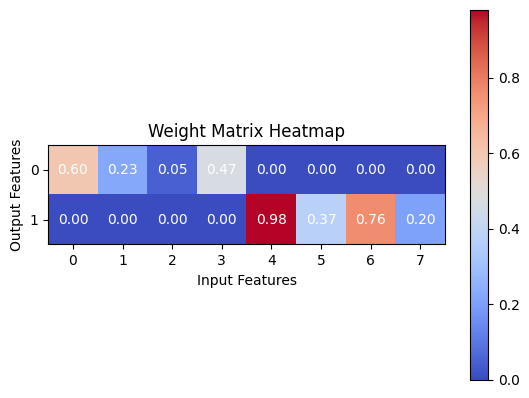

In [212]:
hvc_neurons = 4
syllable_features = 1
syllable_count = 1
epochs = 10 

model = Model(syllable_count, hvc_neurons, syllable_features)

dummy_HVC_input = torch.zeros(syllable_count)

# initial hidden state
hidden_state = torch.zeros(hvc_neurons)

for epoch in range(epochs):
    # hidden_state = model.forward_HVC(dummy_HVC_input, hidden_state)
    # ra_output = model.forward_RA(hidden_state)
    # print(hidden_state)
    # print(ra_output)
    # weight_matrix = model.hebbian_update(ra_output, hidden_state, learning_rate=0.001)
    # model.set_weights("RA", weight_matrix)
    # model.print_layer_weights("RA")

    hidden_state = model.forward_HVC(dummy_HVC_input, hidden_state)
    Area_X_output = model.forward_Area_X(hidden_state)
    # print(Area_X_output)

    model.visualize_layer_weights("LMAN")
    break